# 🎓 ECE685 Project 2: Multi-Layer SAE-Guided LLM Safety

## Exploring Sparsity Across Multiple Layers via Sparse Autoencoders

This notebook investigates how **Sparse Autoencoders (SAEs)** at **multiple layers** can improve interpretation and safety.

### Multi-Layer Approach:
Per TA Zihao's suggestion, we hook SAEs at **both layer 12 AND layer 20** to potentially boost performance:
- **Layer 12** (mid-layer): Captures structural/syntactic patterns
- **Layer 20** (late-layer): Captures semantic/contextual patterns

### What We'll Do:
1. **Load models**: Gemma-2-2B-IT + pretrained SAEs from Gemma Scope for layers 12 & 20
2. **Capture activations**: Hook BOTH layers, encode with respective SAEs
3. **Feature discovery**: Identify F⁺/F⁻ features for each layer AND combined
4. **Detection**: Compare L12-only vs L20-only vs Multi-layer classifiers
5. **Steering**: Apply steering vectors at both layers simultaneously

### Datasets:
- **NQ-Open** (validation): Question answering → hallucination detection
- **RealToxicityPrompts**: Toxic prompts → safety detection  
- **Anthropic HH**: Harmless prompts → baseline for safety

## 🔧 Setup: Install Dependencies & Login to HuggingFace

### ⚠️ IMPORTANT: Follow These Steps Exactly!

| Step | Action |
|------|--------|
| 1️⃣ | **Run the installation cell below** (wait for it to finish, ~2-3 min) |
| 2️⃣ | **RESTART THE RUNTIME**: Click `Runtime → Restart runtime` |
| 3️⃣ | **After restart, SKIP the installation cell** (don't run it again!) |
| 4️⃣ | **Run the verification cell** to confirm everything works |
| 5️⃣ | Continue with the HuggingFace login and rest of notebook |

> 🛑 **Why restart?** Google Colab caches numpy in memory. After installing a new version, you MUST restart for Python to use the new version. If you skip the restart, you'll get a `numpy.dtype size changed` error.


In [3]:
!nvidia-smi

Wed Dec  3 05:00:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   37C    P0             56W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
# ============================================================================
# STEP 1: Install dependencies (RUN THIS FIRST, THEN RESTART!)
# ============================================================================
#
# ⚠️  CRITICAL: After this cell finishes, you MUST:
#     1. Click Runtime → Restart runtime (or Ctrl+M .)
#     2. After restart, SKIP this cell
#     3. Run the verification cell below
#
# ============================================================================

# Uninstall any existing numpy first to avoid conflicts
%pip uninstall -y numpy
# Install compatible numpy version
%pip install numpy==1.26.4
# Install other dependencies
%pip install -q transformers accelerate datasets torch pandas matplotlib scikit-learn tqdm
# Install sae-lens (must be after numpy to avoid conflicts)
%pip install -q sae-lens



Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you 

In [1]:
# ============================================================================
# STEP 2: Verify installation (run AFTER restarting runtime)
# ============================================================================
# If you get a numpy error here, you forgot to restart the runtime!
# Go back and follow the instructions in the installation cell.
# ============================================================================

import numpy as np
print(f"NumPy version: {np.__version__}")

# Check if numpy version is compatible
if np.__version__.startswith("2."):
    print("\n" + "="*70)
    print("❌ ERROR: Wrong NumPy version detected!")
    print("="*70)
    print(f"\n   You have NumPy {np.__version__}, but need 1.26.x")
    print("\n   This means you did NOT restart the runtime after installation.")
    print("\n   FIX: Click Runtime → Restart runtime, then run THIS cell again")
    print("        (skip the installation cell after restart)")
    print("="*70)
    raise RuntimeError("Please restart the runtime and try again!")

print(f"✓ NumPy version: {np.__version__} (compatible)")

import sae_lens
print(f"✓ sae-lens version: {sae_lens.__version__}")

import torch
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

import transformers
from tqdm import tqdm
print(f"✓ transformers version: {transformers.__version__}")

print("\n" + "="*50)
print("✅ All packages loaded successfully!")
print("="*50)
print("\nYou can now proceed with the rest of the notebook.")


NumPy version: 1.26.4
✓ NumPy version: 1.26.4 (compatible)
✓ sae-lens version: 6.22.3
✓ PyTorch version: 2.9.0+cu126
✓ CUDA available: True
  GPU: NVIDIA A100-SXM4-80GB
✓ transformers version: 4.57.2

✅ All packages loaded successfully!

You can now proceed with the rest of the notebook.


In [ ]:
# Login to HuggingFace (required for Gemma access)
# You need to accept the license at: https://huggingface.co/google/gemma-2b-it
from huggingface_hub import login
login("")  # Enter your HuggingFace token when prompted


## 📦 Configuration & Helper Classes

These classes wrap the models and provide a clean interface. All code is inline for Colab compatibility.


In [3]:
# ============================================================================
# MULTI-LAYER CONFIGURATION
# ============================================================================
from dataclasses import dataclass, field
from pathlib import Path
from typing import Literal, Optional, Dict, Any, List
import json

@dataclass
class MultiLayerConfig:
    """Multi-layer project configuration - hook SAEs at multiple layers"""
    # Model settings - using Gemma 2 2B IT (hidden_size=2304) to match SAE
    gemma_model_name: str = "google/gemma-2-2b-it"
    toxicity_model_name: str = "unitary/unbiased-toxic-roberta"
    dtype: str = "bfloat16"

    # ========================================================================
    # MULTI-LAYER SETTINGS: Hook SAEs at layers 12 AND 20
    # Layer 12: mid-layer (structural patterns)
    # Layer 20: late-layer (semantic patterns)
    # ========================================================================
    hook_layers: List[int] = field(default_factory=lambda: [12, 20])

    # SAE settings per layer (Gemma Scope) - for Gemma 2 2B
    sae_release: str = "gemma-scope-2b-pt-res-canonical"
    sae_ids: Dict[int, str] = field(default_factory=lambda: {
        12: "layer_12/width_16k/canonical",
        20: "layer_20/width_16k/canonical"
    })

    # Data settings - USE ALL AVAILABLE DATA (matching Combined.ipynb)
    # nq_sample_limit: int = 3610   # NQ-Open has ~3610 validation samples, use all
    # hh_sample_limit: int = 8552   # Anthropic HH has ~8552 samples, use all
    # rtp_sample_limit: int = 8552  # Sample this many from RTP to balance with HH
    nq_sample_limit: int = 2   # NQ-Open has ~3610 validation samples, use all
    hh_sample_limit: int = 2   # Anthropic HH has ~8552 samples, use all
    rtp_sample_limit: int = 2  # Sample this many from RTP to balance with HH

    # Batch sizes (matching Combined.ipynb)
    data_batch_size: int = 64     # Batch size for data processing (larger for speed)
    steering_batch_size: int = 16 # Batch size for steering experiments

    # Steering experiment settings (matching Combined.ipynb)
    steering_samples: int = 200   # 200 samples for steering experiments
    steering_strength_ratios: list = field(default_factory=lambda: [0.0, 0.05, 0.1, 0.2, 0.3])

    # Feature discovery settings
    top_k_features: int = 100  # Top features per layer

    # Experiment settings
    device: str = "cuda"
    seed: int = 42

    @property
    def n_features_per_layer(self) -> int:
        """16k features per layer"""
        return 16384

    @property
    def total_features(self) -> int:
        """Total features when combining all layers"""
        return self.n_features_per_layer * len(self.hook_layers)

CONFIG = MultiLayerConfig()
print(f"✓ Multi-Layer Config loaded (COMPREHENSIVE MODE - GPU)")
print(f"  Model: {CONFIG.gemma_model_name}")
print(f"  Hook Layers: {CONFIG.hook_layers}")
print(f"  SAE Release: {CONFIG.sae_release}")
print(f"  SAE IDs:")
for layer, sae_id in CONFIG.sae_ids.items():
    print(f"    Layer {layer}: {sae_id}")
print(f"  Features: {CONFIG.n_features_per_layer} per layer × {len(CONFIG.hook_layers)} layers = {CONFIG.total_features} total")
print(f"  Data limits: NQ={CONFIG.nq_sample_limit}, HH={CONFIG.hh_sample_limit}, RTP={CONFIG.rtp_sample_limit}")
print(f"  Batch sizes: data={CONFIG.data_batch_size}, steering={CONFIG.steering_batch_size}")
print(f"  Steering samples: {CONFIG.steering_samples}")
print(f"  Steering ratios (of ‖h‖): {CONFIG.steering_strength_ratios}")
n_modes = 2  # layer_12, layer_20
print(f"  Total steering generations: {CONFIG.steering_samples} × {len(CONFIG.steering_strength_ratios)} × {n_modes} modes × 2 tasks = {CONFIG.steering_samples * len(CONFIG.steering_strength_ratios) * n_modes * 2}")

✓ Multi-Layer Config loaded (COMPREHENSIVE MODE - GPU)
  Model: google/gemma-2-2b-it
  Hook Layers: [12, 20]
  SAE Release: gemma-scope-2b-pt-res-canonical
  SAE IDs:
    Layer 12: layer_12/width_16k/canonical
    Layer 20: layer_20/width_16k/canonical
  Features: 16384 per layer × 2 layers = 32768 total
  Data limits: NQ=2, HH=2, RTP=2
  Batch sizes: data=64, steering=16
  Steering samples: 200
  Steering ratios (of ‖h‖): [0.0, 0.05, 0.1, 0.2, 0.3]
  Total steering generations: 200 × 5 × 3 modes × 2 tasks = 6000


In [4]:
# ============================================================================
# MULTI-LAYER SPARSE AUTOENCODER WRAPPER
# ============================================================================
import torch
from sae_lens import SAE
import numpy as np

@dataclass
class SingleLayerSAE:
    """Wrapper for a single layer's SAE with encode/decode methods"""
    layer_idx: int
    encoder_weight: torch.Tensor  # [n_features, d_model]
    decoder_weight: torch.Tensor  # [n_features, d_model]
    bias: torch.Tensor            # [n_features]
    n_features: int
    device: str = "cpu"

    @torch.inference_mode()
    def encode(self, residual: torch.Tensor) -> torch.Tensor:
        """Encode residual activations to sparse SAE codes"""
        original_shape = residual.shape
        residual = residual.float().cpu()

        if residual.dim() == 3:
            residual = residual.reshape(-1, residual.size(-1))

        projected = torch.nn.functional.linear(residual, self.encoder_weight, self.bias)
        codes = torch.nn.functional.relu(projected)

        if len(original_shape) == 3:
            codes = codes.reshape(original_shape[0], original_shape[1], -1)

        return codes

    @torch.inference_mode()
    def decode(self, codes: torch.Tensor) -> torch.Tensor:
        """Decode SAE codes back to residual space"""
        return torch.nn.functional.linear(codes, self.decoder_weight.t())


class MultiLayerSAE:
    """
    Multi-layer SAE manager that loads and manages SAEs for multiple layers.
    Supports encoding from any single layer or all layers concatenated.
    """

    def __init__(self):
        self.saes: Dict[int, SingleLayerSAE] = {}
        self.layer_order: List[int] = []

    @classmethod
    def load(cls, config: MultiLayerConfig) -> "MultiLayerSAE":
        """Load pretrained SAEs for all configured layers"""
        instance = cls()

        print(f"Loading Multi-Layer SAEs from Gemma Scope...")
        print(f"  Release: {config.sae_release}")
        print(f"  Layers: {config.hook_layers}")

        for layer_idx in config.hook_layers:
            sae_id = config.sae_ids[layer_idx]
            print(f"\n  Loading SAE for layer {layer_idx}: {sae_id}...")

            sae, cfg_dict, sparsity = SAE.from_pretrained(
                release=config.sae_release,
                sae_id=sae_id,
                device="cpu",
            )

            print(f"    ✓ Features: {sae.cfg.d_sae}, Hidden size: {sae.cfg.d_in}")

            # W_enc: (d_in, d_sae) → transpose to (d_sae, d_in)
            encoder_w = sae.W_enc.detach().cpu().t()
            decoder_w = sae.W_dec.detach().cpu()

            single_sae = SingleLayerSAE(
                layer_idx=layer_idx,
                encoder_weight=encoder_w,
                decoder_weight=decoder_w,
                bias=sae.b_enc.detach().cpu() if hasattr(sae, "b_enc") else torch.zeros(sae.cfg.d_sae),
                n_features=sae.cfg.d_sae,
            )
            instance.saes[layer_idx] = single_sae
            instance.layer_order.append(layer_idx)

        print(f"\n✓ Multi-Layer SAE loaded!")
        print(f"  Total layers: {len(instance.saes)}")
        print(f"  Features per layer: {config.n_features_per_layer}")
        print(f"  Total features (concatenated): {config.total_features}")

        return instance

    def encode_single_layer(self, residual: torch.Tensor, layer_idx: int) -> torch.Tensor:
        """Encode residual from a single layer"""
        if layer_idx not in self.saes:
            raise ValueError(f"No SAE loaded for layer {layer_idx}")
        return self.saes[layer_idx].encode(residual)

    def encode_all_layers(self, residuals: Dict[int, torch.Tensor]) -> torch.Tensor:
        """
        Encode residuals from all layers and concatenate.

        Args:
            residuals: Dict mapping layer_idx → residual tensor

        Returns:
            Concatenated codes [n_features_layer1, n_features_layer2, ...]
        """
        codes_list = []
        for layer_idx in self.layer_order:
            if layer_idx not in residuals:
                raise ValueError(f"Missing residual for layer {layer_idx}")
            codes = self.saes[layer_idx].encode(residuals[layer_idx])
            codes_list.append(codes)

        # Concatenate along feature dimension
        return torch.cat(codes_list, dim=-1)

    def get_codes_dict(self, residuals: Dict[int, torch.Tensor]) -> Dict[str, np.ndarray]:
        """
        Get codes for each layer individually AND concatenated.

        Returns:
            Dict with keys: 'layer_12', 'layer_20', 'multi_layer'
        """
        result = {}
        codes_list = []

        for layer_idx in self.layer_order:
            if layer_idx not in residuals:
                raise ValueError(f"Missing residual for layer {layer_idx}")
            codes = self.saes[layer_idx].encode(residuals[layer_idx])
            result[f'layer_{layer_idx}'] = codes.squeeze(0).numpy()
            codes_list.append(codes)

        # Concatenate for multi-layer
        multi_codes = torch.cat(codes_list, dim=-1)
        result['multi_layer'] = multi_codes.squeeze(0).numpy()

        return result

    def build_steering_vector(self, layer_idx: int, f_plus_ids: list, f_minus_ids: list,
                               plus_weight: float = -1.0, minus_weight: float = 1.0) -> torch.Tensor:
        """
        Build steering vector for a specific layer from F⁺ and F⁻ features.
        """
        if layer_idx not in self.saes:
            raise ValueError(f"No SAE loaded for layer {layer_idx}")

        sae = self.saes[layer_idx]
        d_in = sae.decoder_weight.shape[1]
        direction = torch.zeros(d_in)

        for idx in f_plus_ids:
            if idx < sae.n_features:
                direction += plus_weight * sae.decoder_weight[idx]
        for idx in f_minus_ids:
            if idx < sae.n_features:
                direction += minus_weight * sae.decoder_weight[idx]

        if direction.norm() > 0:
            direction = direction / direction.norm()

        return direction

print("✓ MultiLayerSAE class defined")

✓ MultiLayerSAE class defined


In [5]:
# ============================================================================
# MULTI-LAYER GEMMA INTERFACE WITH ACTIVATION HOOKS
# ============================================================================
from contextlib import contextmanager
from transformers import AutoModelForCausalLM, AutoTokenizer

@dataclass
class MultiLayerResidualCapture:
    """Captures residual stream activations from MULTIPLE layers"""
    layer_indices: List[int]
    residuals: Dict[int, torch.Tensor] = field(default_factory=dict)

    def create_hook(self, layer_idx: int):
        """Create a hook function for a specific layer"""
        def hook_fn(module, inputs, output):
            if isinstance(output, tuple):
                output = output[0]
            self.residuals[layer_idx] = output.detach()
        return hook_fn

    def clear(self):
        """Clear captured residuals"""
        self.residuals = {}


class MultiLayerGemmaInterface:
    """
    Wrapper for Gemma with multi-layer activation capture and steering hooks.
    Captures residuals from ALL configured layers simultaneously.
    """

    def __init__(self, model_name: str = None, config: MultiLayerConfig = None):
        self.config = config or CONFIG
        model_id = model_name or self.config.gemma_model_name
        dtype = getattr(torch, self.config.dtype)

        print(f"Loading {model_id}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_id,
            torch_dtype=dtype,
            device_map="auto",
        )

        self.capture = MultiLayerResidualCapture(layer_indices=self.config.hook_layers)
        self._activation_handles: Dict[int, Any] = {}
        self._steering_handles: Dict[int, Any] = {}

        print(f"✓ Gemma loaded on {self.model.device}")
        print(f"  Hooking layers: {self.config.hook_layers}")

    def register_capture_hooks(self):
        """Register capture hooks for ALL configured layers"""
        for layer_idx in self.config.hook_layers:
            if layer_idx not in self._activation_handles:
                block = self.model.model.layers[layer_idx]
                hook_fn = self.capture.create_hook(layer_idx)
                self._activation_handles[layer_idx] = block.register_forward_hook(hook_fn)

    def register_steering_hook(self, layer_idx: int, steering_vector: torch.Tensor, strength: float):
        """Register steering hook for a specific layer"""
        def steering_fn(module, inputs, output):
            is_tuple = isinstance(output, tuple)
            hidden_states = output[0] if is_tuple else output

            shifted = hidden_states.clone()
            steer = steering_vector.to(shifted.device).to(shifted.dtype) * strength
            shifted[:, -1, :] += steer

            if is_tuple:
                return (shifted,) + output[1:] if len(output) > 1 else (shifted,)
            return shifted

        block = self.model.model.layers[layer_idx]
        self._steering_handles[layer_idx] = block.register_forward_hook(steering_fn)

    def remove_hooks(self):
        """Remove all registered hooks"""
        for handle in self._activation_handles.values():
            if handle is not None:
                handle.remove()
        for handle in self._steering_handles.values():
            if handle is not None:
                handle.remove()
        self._activation_handles = {}
        self._steering_handles = {}
        self.capture.clear()

    @contextmanager
    def capture_residuals(self, steering_vectors: Optional[Dict[int, torch.Tensor]] = None,
                          strengths: Optional[Dict[int, float]] = None):
        """
        Context manager to capture residuals from all layers.
        Optionally applies steering at specified layers.
        """
        self.capture.clear()
        self.register_capture_hooks()

        if steering_vectors and strengths:
            for layer_idx, vec in steering_vectors.items():
                if layer_idx in strengths and strengths[layer_idx] != 0.0:
                    self.register_steering_hook(layer_idx, vec, strengths[layer_idx])
        try:
            yield self.capture
        finally:
            self.remove_hooks()

    @torch.inference_mode()
    def generate(self, prompt: str, max_new_tokens: int = 50,
                 steering_vectors: Optional[Dict[int, torch.Tensor]] = None,
                 strengths: Optional[Dict[int, float]] = None) -> dict:
        """Generate text with optional multi-layer steering and residual capture"""
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

        with self.capture_residuals(steering_vectors, strengths):
            output_ids = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=self.tokenizer.eos_token_id,
            )

        text = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # Get last token residuals for each layer
        residuals = {}
        for layer_idx, res in self.capture.residuals.items():
            if res is not None:
                residuals[layer_idx] = res[:, -1, :].detach().cpu()

        return {"text": text, "residuals": residuals}

    @torch.inference_mode()
    def generate_batch(self, prompts: list, max_new_tokens: int = 50,
                       steering_vectors: Optional[Dict[int, torch.Tensor]] = None,
                       strengths: Optional[Dict[int, float]] = None) -> list:
        """
        Batch generate text with optional multi-layer steering and residual capture.
        """
        if not prompts:
            return []

        self.tokenizer.pad_token = self.tokenizer.eos_token
        inputs = self.tokenizer(
            prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(self.model.device)

        # Store residuals for each layer
        batch_residuals: Dict[int, list] = {layer: [] for layer in self.config.hook_layers}

        def create_batch_hook(layer_idx):
            def hook_fn(module, inp, output):
                hidden = output[0] if isinstance(output, tuple) else output
                batch_residuals[layer_idx].append(hidden.detach().cpu())
            return hook_fn

        # Register hooks
        handles = []
        for layer_idx in self.config.hook_layers:
            block = self.model.model.layers[layer_idx]
            handle = block.register_forward_hook(create_batch_hook(layer_idx))
            handles.append(handle)

        try:
            output_ids = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=self.tokenizer.eos_token_id,
            )
        finally:
            for handle in handles:
                handle.remove()

        texts = self.tokenizer.batch_decode(output_ids, skip_special_tokens=True)

        results = []
        for i, text in enumerate(texts):
            residuals = {}
            for layer_idx in self.config.hook_layers:
                if batch_residuals[layer_idx]:
                    last_hidden = batch_residuals[layer_idx][0]
                    if i < last_hidden.shape[0]:
                        seq_len = (inputs['attention_mask'][i] == 1).sum().item()
                        residuals[layer_idx] = last_hidden[i, seq_len-1, :].unsqueeze(0)

            results.append({
                "text": text,
                "residuals": residuals
            })

        return results

    @torch.inference_mode()
    def forward_batch(self, prompts: list) -> list:
        """
        Run forward pass only (no generation) to capture multi-layer residuals.
        Much faster for activation capture when you don't need generated text.
        """
        if not prompts:
            return []

        self.tokenizer.pad_token = self.tokenizer.eos_token
        inputs = self.tokenizer(
            prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(self.model.device)

        self.register_capture_hooks()
        try:
            _ = self.model(**inputs, output_hidden_states=False)

            results = []
            for i in range(len(prompts)):
                residuals = {}
                seq_len = (inputs['attention_mask'][i] == 1).sum().item()
                for layer_idx in self.config.hook_layers:
                    if layer_idx in self.capture.residuals:
                        residuals[layer_idx] = self.capture.residuals[layer_idx][i, seq_len-1, :].unsqueeze(0).cpu()
                results.append(residuals)
        finally:
            self.remove_hooks()

        return results

print("✓ MultiLayerGemmaInterface class defined")

✓ MultiLayerGemmaInterface class defined


In [6]:
# ============================================================================
# TOXICITY CLASSIFIER WRAPPER
# ============================================================================
from transformers import AutoModelForSequenceClassification

@dataclass
class ToxicityScore:
    probability: float
    label: int  # 1 = toxic, 0 = safe


class ToxicityWrapper:
    """Wrapper for toxicity classification model"""

    def __init__(self, model_name: str = None):
        model_id = model_name or CONFIG.toxicity_model_name
        print(f"Loading toxicity classifier: {model_id}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_id)
        self.model.eval()
        print("✓ Toxicity classifier loaded")

    @torch.inference_mode()
    def score(self, text: str, threshold: float = 0.5) -> ToxicityScore:
        """Score text for toxicity"""
        if not text or len(text.strip()) == 0:
            return ToxicityScore(probability=0.0, label=0)

        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        logits = self.model(**inputs).logits
        probs = torch.softmax(logits, dim=-1)
        prob = probs[0, 1].item()  # Probability of toxic class
        return ToxicityScore(probability=prob, label=int(prob >= threshold))

print("✓ ToxicityWrapper class defined")


✓ ToxicityWrapper class defined


---

# 🚀 Part 1: Load Models & Prepare Data

Now we load all three models:
1. **Gemma-2B-IT**: The base LLM for text generation
2. **SAE (Gemma Scope)**: Pretrained sparse autoencoder for layer 12
3. **Toxicity Classifier**: For labeling safe/unsafe completions


In [7]:
# ============================================================================
# LOAD ALL MODELS (MULTI-LAYER)
# ============================================================================
print("=" * 60)
print("LOADING MODELS (MULTI-LAYER)")
print("=" * 60)

# 1. Load Gemma with multi-layer hooks
gemma = MultiLayerGemmaInterface(config=CONFIG)
hidden_size = gemma.model.config.hidden_size
print(f"  Hidden size: {hidden_size}")

# 2. Load Multi-Layer SAE (both layer 12 and layer 20)
print()
sae = MultiLayerSAE.load(CONFIG)

# 3. Load toxicity classifier
print()
tox = ToxicityWrapper()

print("\n" + "=" * 60)
print("✓ ALL MODELS LOADED SUCCESSFULLY!")
print("  - Gemma-2-2B-IT with hooks at layers", CONFIG.hook_layers)
print("  - Multi-Layer SAE (32k features total)")
print("  - Toxicity classifier")
print("=" * 60)

LOADING MODELS (MULTI-LAYER)
Loading google/gemma-2-2b-it...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

✓ Gemma loaded on cuda:0
  Hooking layers: [12, 20]
  Hidden size: 2304

Loading Multi-Layer SAEs from Gemma Scope...
  Release: gemma-scope-2b-pt-res-canonical
  Layers: [12, 20]

  Loading SAE for layer 12: layer_12/width_16k/canonical...


layer_12/width_16k/average_l0_82/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

/tmp/ipython-input-296576845.py:64: DeprecationWarning: Unpacking SAE objects is deprecated. SAE.from_pretrained() now returns only the SAE object. Use SAE.from_pretrained_with_cfg_and_sparsity() to get the config dict and sparsity as well.
  sae, cfg_dict, sparsity = SAE.from_pretrained(


    ✓ Features: 16384, Hidden size: 2304

  Loading SAE for layer 20: layer_20/width_16k/canonical...


layer_20/width_16k/average_l0_71/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

    ✓ Features: 16384, Hidden size: 2304

✓ Multi-Layer SAE loaded!
  Total layers: 2
  Features per layer: 16384
  Total features (concatenated): 32768

Loading toxicity classifier: unitary/unbiased-toxic-roberta...


tokenizer_config.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

✓ Toxicity classifier loaded

✓ ALL MODELS LOADED SUCCESSFULLY!
  - Gemma-2-2B-IT with hooks at layers [12, 20]
  - Multi-Layer SAE (32k features total)
  - Toxicity classifier


In [8]:
# ============================================================================
# CALIBRATE STEERING STRENGTH (MULTI-LAYER)
# ============================================================================
# Measure typical residual norm at each layer to properly calibrate steering

def calibrate_multilayer_steering(gemma, sample_prompts: list, n_samples: int = 50):
    """
    Measure typical residual norm at each layer to calibrate steering strength.
    Returns mean norms per layer and computed alpha values.
    """
    print("Calibrating multi-layer steering strengths...")

    norms_per_layer = {layer: [] for layer in CONFIG.hook_layers}

    for i, prompt in enumerate(tqdm(sample_prompts[:n_samples], desc="Measuring residual norms")):
        result = gemma.generate(prompt, max_new_tokens=1)
        for layer_idx, res in result['residuals'].items():
            if res is not None:
                norm = res.norm().item()
                norms_per_layer[layer_idx].append(norm)

    mean_norms = {}
    alphas_per_layer = {}

    print(f"\n  Residual stream statistics per layer:")
    for layer_idx in CONFIG.hook_layers:
        norms = norms_per_layer[layer_idx]
        mean_norm = np.mean(norms)
        std_norm = np.std(norms)
        mean_norms[layer_idx] = mean_norm

        # Compute alpha values for this layer
        alphas = [ratio * mean_norm for ratio in CONFIG.steering_strength_ratios]
        alphas_per_layer[layer_idx] = alphas

        print(f"    Layer {layer_idx}: Mean ‖h‖ = {mean_norm:.2f} ± {std_norm:.2f}")
        print(f"      α values: {[f'{a:.2f}' for a in alphas]}")

    return mean_norms, alphas_per_layer

# Use simple calibration prompts (50 total, matching Combined.ipynb)
calibration_prompts = [
    "What is the capital of France?",
    "How does photosynthesis work?",
    "Explain quantum computing.",
    "What causes climate change?",
    "Who wrote Romeo and Juliet?",
    "What is machine learning?",
    "How do vaccines work?",
    "What is the speed of light?",
    "Explain the theory of relativity.",
    "What is DNA?",
] * 5  # 50 prompts total

MEAN_NORMS, ALPHAS_PER_LAYER = calibrate_multilayer_steering(gemma, calibration_prompts, n_samples=50)

# Use average of layer norms for unified steering strength
MEAN_RESIDUAL_NORM = np.mean(list(MEAN_NORMS.values()))
STEERING_ALPHAS = [ratio * MEAN_RESIDUAL_NORM for ratio in CONFIG.steering_strength_ratios]

print(f"\n✓ Multi-layer calibration complete!")
print(f"  Mean norms per layer: {MEAN_NORMS}")
print(f"  Overall MEAN_RESIDUAL_NORM = {MEAN_RESIDUAL_NORM:.2f}")
print(f"  STEERING_ALPHAS = {[f'{a:.2f}' for a in STEERING_ALPHAS]}")

Calibrating multi-layer steering strengths...


Measuring residual norms:  50%|█████     | 25/50 [00:02<00:01, 21.65it/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Measuring residual norms: 100%|██████████| 50/50 [00:03<00:00, 16.13it/s]


  Residual stream statistics per layer:
    Layer 12: Mean ‖h‖ = nan ± nan
      α values: ['nan', 'nan', 'nan', 'nan', 'nan']
    Layer 20: Mean ‖h‖ = nan ± nan
      α values: ['nan', 'nan', 'nan', 'nan', 'nan']

✓ Multi-layer calibration complete!
  Mean norms per layer: {12: nan, 20: nan}
  Overall MEAN_RESIDUAL_NORM = nan
  STEERING_ALPHAS = ['nan', 'nan', 'nan', 'nan', 'nan']



/usr/local/lib/python3.12/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## 📊 Load Datasets from HuggingFace

We use three datasets:
- **NQ-Open**: Natural Questions for hallucination detection (has ground truth answers)
- **RealToxicityPrompts**: Challenging prompts that often elicit toxic responses
- **Anthropic HH**: Harmless/helpful prompts as a safe baseline


In [9]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load datasets
print("Loading datasets from HuggingFace...")

# NQ-Open: Question answering with ground truth
nq_dataset = load_dataset("nq_open", split="validation")
print(f"✓ NQ-Open: {len(nq_dataset)} samples")

# RealToxicityPrompts: Toxic prompt continuation
rtp_dataset = load_dataset("allenai/real-toxicity-prompts", split="train")
print(f"✓ RealToxicityPrompts: {len(rtp_dataset)} samples")

# Anthropic HH: Safe conversations
hh_dataset = load_dataset("Anthropic/hh-rlhf", split="test")
print(f"✓ Anthropic HH: {len(hh_dataset)} samples")


Loading datasets from HuggingFace...


README.md: 0.00B [00:00, ?B/s]

nq_open/train-00000-of-00001.parquet:   0%|          | 0.00/4.46M [00:00<?, ?B/s]

nq_open/validation-00000-of-00001.parque(…):   0%|          | 0.00/214k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87925 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3610 [00:00<?, ? examples/s]

✓ NQ-Open: 3610 samples


README.md: 0.00B [00:00, ?B/s]

prompts.jsonl:   0%|          | 0.00/67.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/99442 [00:00<?, ? examples/s]

✓ RealToxicityPrompts: 99442 samples


README.md: 0.00B [00:00, ?B/s]

harmless-base/train.jsonl.gz:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

helpful-base/train.jsonl.gz:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

helpful-online/train.jsonl.gz:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

helpful-rejection-sampled/train.jsonl.gz:   0%|          | 0.00/25.7M [00:00<?, ?B/s]

harmless-base/test.jsonl.gz:   0%|          | 0.00/743k [00:00<?, ?B/s]

helpful-base/test.jsonl.gz:   0%|          | 0.00/875k [00:00<?, ?B/s]

helpful-online/test.jsonl.gz:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

helpful-rejection-sampled/test.jsonl.gz:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/160800 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8552 [00:00<?, ? examples/s]

✓ Anthropic HH: 8552 samples


## 🔬 Capture Activations & Generate Labels

For each prompt, we:
1. Run it through Gemma to capture layer 12 residuals
2. Encode the residual with SAE to get sparse feature codes
3. Generate a label (hallucination or toxicity)

### Improved Hallucination Labeling

The original code used answer length as a proxy for hallucination, which produced very few positive samples.

**Better approach**: Compare model answers to the **ground truth answers** in NQ-Open using string matching.


In [10]:
def check_hallucination(model_answer: str, ground_truth_answers: list) -> bool:
    """
    Check if model answer is a hallucination by comparing to ground truth.
    Returns True if the answer is likely hallucinated.
    """
    model_answer_lower = model_answer.lower().strip()

    if len(model_answer_lower.split()) < 2:
        return True

    for gt in ground_truth_answers:
        gt_lower = gt.lower().strip()
        if gt_lower in model_answer_lower or model_answer_lower in gt_lower:
            return False

        gt_words = set(gt_lower.split())
        answer_words = set(model_answer_lower.split())
        overlap = len(gt_words & answer_words)
        if overlap >= min(2, len(gt_words)):
            return False

    return True


# ============================================================================
# BATCH SIZES
# ============================================================================
DATA_BATCH_SIZE = CONFIG.data_batch_size
STEERING_BATCH_SIZE = CONFIG.steering_batch_size


def process_nq_open_multilayer(dataset, limit: int, batch_size: int = None) -> pd.DataFrame:
    """
    Process NQ-Open dataset for hallucination detection - MULTI-LAYER VERSION.
    Stores codes for each layer individually AND concatenated.
    """
    if batch_size is None:
        batch_size = DATA_BATCH_SIZE

    questions = []
    ground_truths = []

    for i, row in enumerate(dataset):
        if i >= limit:
            break
        questions.append(row['question'])
        ground_truths.append(row['answer'])

    print(f"  Processing {len(questions)} questions in batches of {batch_size}...")

    records = []

    for batch_start in tqdm(range(0, len(questions), batch_size), desc="Processing NQ-Open"):
        batch_end = min(batch_start + batch_size, len(questions))
        batch_questions = questions[batch_start:batch_end]
        batch_gt = ground_truths[batch_start:batch_end]

        # Batch generate with multi-layer residual capture
        results = gemma.generate_batch(batch_questions, max_new_tokens=50)

        for j, (question, gt, result) in enumerate(zip(batch_questions, batch_gt, results)):
            if not result['residuals']:
                continue

            model_answer = result['text'].replace(question, '').strip()

            # Encode with multi-layer SAE - get codes for each layer AND concatenated
            codes_dict = sae.get_codes_dict(result['residuals'])

            is_hallucinated = check_hallucination(model_answer, gt)

            record = {
                'id': batch_start + j,
                'prompt': question,
                'model_answer': model_answer,
                'ground_truth': gt,
                'label': int(is_hallucinated),
            }
            # Add codes for each layer and multi-layer
            for key, codes in codes_dict.items():
                record[f'codes_{key}'] = codes

            records.append(record)

    df = pd.DataFrame(records)
    n_halluc = df['label'].sum()
    print(f"✓ NQ-Open: {len(df)} samples, {n_halluc} hallucinated ({n_halluc/len(df)*100:.1f}%)")
    print(f"  Codes stored: {[k for k in df.columns if k.startswith('codes_')]}")
    return df


# Alias for compatibility
def process_nq_open(dataset, limit: int) -> pd.DataFrame:
    return process_nq_open_multilayer(dataset, limit, batch_size=DATA_BATCH_SIZE)


print(f"✓ Multi-layer hallucination detection functions defined (batch_size={DATA_BATCH_SIZE})")

✓ Multi-layer hallucination detection functions defined (batch_size=64)


In [11]:
def process_toxicity_multilayer(dataset, name: str, limit: int,
                                  text_field: str = 'prompt',
                                  is_toxic_baseline: bool = True,
                                  batch_size: int = None) -> pd.DataFrame:
    """
    Process toxicity dataset - MULTI-LAYER VERSION.
    Stores codes for each layer individually AND concatenated.
    """
    if batch_size is None:
        batch_size = DATA_BATCH_SIZE

    prompts = []
    indices = []

    for i, row in enumerate(dataset):
        if len(prompts) >= limit:
            break

        if text_field == 'prompt' and isinstance(row.get('prompt'), dict):
            prompt = row['prompt'].get('text', '')
        elif text_field == 'chosen':
            text = row['chosen']
            if 'Human:' in text:
                prompt = text.split('Human:')[1].split('Assistant:')[0].strip()
            else:
                prompt = text[:200]
        else:
            prompt = row.get(text_field, '')

        if not prompt or len(prompt) < 5:
            continue

        prompts.append(prompt[:500])
        indices.append(i)

    print(f"  Processing {len(prompts)} prompts in batches of {batch_size}...")

    records = []

    for batch_start in tqdm(range(0, len(prompts), batch_size), desc=f"Processing {name}"):
        batch_end = min(batch_start + batch_size, len(prompts))
        batch_prompts = prompts[batch_start:batch_end]
        batch_indices = indices[batch_start:batch_end]

        results = gemma.generate_batch(batch_prompts, max_new_tokens=50)

        for j, (prompt, idx, result) in enumerate(zip(batch_prompts, batch_indices, results)):
            if not result['residuals']:
                continue

            completion = result['text'].replace(prompt, '').strip()

            # Encode with multi-layer SAE
            codes_dict = sae.get_codes_dict(result['residuals'])

            tox_score = tox.score(completion)

            record = {
                'id': idx,
                'prompt': prompt,
                'completion': completion,
                'toxicity_probability': tox_score.probability,
                'label': tox_score.label,
            }
            for key, codes in codes_dict.items():
                record[f'codes_{key}'] = codes

            records.append(record)

    df = pd.DataFrame(records)
    n_toxic = df['label'].sum()
    print(f"✓ {name}: {len(df)} samples, {n_toxic} toxic ({n_toxic/len(df)*100:.1f}%)")
    print(f"  Codes stored: {[k for k in df.columns if k.startswith('codes_')]}")
    return df


# Alias for compatibility
def process_toxicity_dataset(dataset, name: str, limit: int,
                              text_field: str = 'prompt',
                              is_toxic_baseline: bool = True) -> pd.DataFrame:
    return process_toxicity_multilayer(dataset, name, limit, text_field, is_toxic_baseline, DATA_BATCH_SIZE)


print(f"✓ Multi-layer toxicity processing functions defined (batch_size={DATA_BATCH_SIZE})")

✓ Multi-layer toxicity processing functions defined (batch_size=64)


In [12]:
# ============================================================================
# PROCESS ALL DATASETS (BATCHED - ~5-10x FASTER!)
# ============================================================================
# Using batch_size=64 for data processing on A100 80GB
# Processing ALL available data:
#   - NQ-Open: all ~3610 validation samples
#   - Anthropic HH: all ~8552 samples
#   - RealToxicityPrompts: sampled to match HH count (balanced dataset)

print(f"\n{'='*60}")
print("PROCESSING DATASETS (FULL DATA)")
print(f"{'='*60}")
print(f"Using batch_size={DATA_BATCH_SIZE} for GPU acceleration")
print(f"  NQ-Open limit: {CONFIG.nq_sample_limit} (use all available)")
print(f"  HH limit: {CONFIG.hh_sample_limit} (use all available)")
print(f"  RTP limit: {CONFIG.rtp_sample_limit} (balanced with HH)\n")

# 1. Process NQ-Open (Hallucination) - use all available
print("1/3: Processing NQ-Open for hallucination detection...")
nq_df = process_nq_open(nq_dataset, limit=CONFIG.nq_sample_limit)

# 2. Process Anthropic HH (Safe) - use all available
print("\n2/3: Processing Anthropic HH (safe baseline)...")
hh_df = process_toxicity_dataset(hh_dataset, "HH", limit=CONFIG.hh_sample_limit,
                                  text_field='chosen', is_toxic_baseline=False)

# 3. Process RealToxicityPrompts (Toxic) - sample to balance with HH
# Randomly shuffle RTP to get different samples each run
import random
random.seed(CONFIG.seed)
rtp_indices = list(range(len(rtp_dataset)))
random.shuffle(rtp_indices)
# Create a shuffled view of the dataset
rtp_shuffled = rtp_dataset.select(rtp_indices[:CONFIG.rtp_sample_limit])

print(f"\n3/3: Processing RealToxicityPrompts (sampled {CONFIG.rtp_sample_limit} to balance with HH)...")
rtp_df = process_toxicity_dataset(rtp_shuffled, "RTP", limit=CONFIG.rtp_sample_limit,
                                   text_field='prompt', is_toxic_baseline=True)

# Combine RTP + HH for safety task
safety_df = pd.concat([rtp_df, hh_df], ignore_index=True)

print(f"\n{'='*60}")
print("DATA PREPARATION COMPLETE!")
print(f"{'='*60}")
print(f"\nHallucination task (NQ-Open):")
print(f"  Total: {len(nq_df)}, Hallucinated: {nq_df['label'].sum()} ({nq_df['label'].mean()*100:.1f}%), "
      f"Correct: {len(nq_df) - nq_df['label'].sum()}")
print(f"\nSafety task (RTP + HH balanced):")
print(f"  Total: {len(safety_df)}")
print(f"  From RTP: {len(rtp_df)}, toxic outputs: {rtp_df['label'].sum()}")
print(f"  From HH:  {len(hh_df)}, toxic outputs: {hh_df['label'].sum()}")



PROCESSING DATASETS (FULL DATA)
Using batch_size=64 for GPU acceleration
  NQ-Open limit: 2 (use all available)
  HH limit: 2 (use all available)
  RTP limit: 2 (balanced with HH)

1/3: Processing NQ-Open for hallucination detection...
  Processing 2 questions in batches of 64...


Processing NQ-Open: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


✓ NQ-Open: 2 samples, 2 hallucinated (100.0%)
  Codes stored: ['codes_layer_12', 'codes_layer_20', 'codes_multi_layer']

2/3: Processing Anthropic HH (safe baseline)...
  Processing 2 prompts in batches of 64...


Processing HH: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


✓ HH: 2 samples, 0 toxic (0.0%)
  Codes stored: ['codes_layer_12', 'codes_layer_20', 'codes_multi_layer']

3/3: Processing RealToxicityPrompts (sampled 2 to balance with HH)...
  Processing 2 prompts in batches of 64...


Processing RTP: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

✓ RTP: 2 samples, 0 toxic (0.0%)
  Codes stored: ['codes_layer_12', 'codes_layer_20', 'codes_multi_layer']

DATA PREPARATION COMPLETE!

Hallucination task (NQ-Open):
  Total: 2, Hallucinated: 2 (100.0%), Correct: 0

Safety task (RTP + HH balanced):
  Total: 4
  From RTP: 2, toxic outputs: 0
  From HH:  2, toxic outputs: 0


---

# 🔍 Part 2: Feature Discovery & Detection

Now we identify which SAE features correlate with risky behavior:

- **F⁺ (Harmful features)**: Activate when the model hallucinates or generates toxic content
- **F⁻ (Protective features)**: Activate when the model is factual or generates safe content

We then train logistic regression classifiers and report:
- **Accuracy**
- **F1 Score**
- **ROC-AUC**


In [13]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score

plt.style.use('seaborn-v0_8-whitegrid')


def discover_features_multilayer(df: pd.DataFrame, task_name: str, top_k: int = 50) -> Dict:
    """
    Find SAE features correlated with the label for EACH layer AND multi-layer.

    Returns:
        Dict with keys 'layer_12', 'layer_20', 'multi_layer', each containing:
            - all_features: DataFrame with all feature correlations
            - f_plus: Top features with positive correlation (harmful)
            - f_minus: Top features with negative correlation (protective)
    """
    labels = df['label'].values
    unique_labels, counts = np.unique(labels, return_counts=True)

    print(f"\n{'='*60}")
    print(f"{task_name.upper()} MULTI-LAYER FEATURE DISCOVERY")
    print(f"{'='*60}")
    print(f"  Label distribution: {dict(zip(unique_labels.astype(int), counts))}")

    results = {}

    # Process each layer configuration
    layer_configs = ['layer_12', 'layer_20', 'multi_layer']

    for layer_key in layer_configs:
        codes_col = f'codes_{layer_key}'
        if codes_col not in df.columns:
            print(f"  ⚠️ Skipping {layer_key}: column {codes_col} not found")
            continue

        codes_matrix = np.stack(df[codes_col].values)
        n_features = codes_matrix.shape[1]

        print(f"\n  --- {layer_key.upper()} ({n_features} features) ---")

        if len(unique_labels) < 2:
            print(f"    ⚠️ Only one class - using variance-based selection")
            feature_variance = codes_matrix.var(axis=0)
            feature_mean = codes_matrix.mean(axis=0)

            correlations = []
            for feat_idx in range(n_features):
                if feature_variance[feat_idx] > 0:
                    correlations.append({
                        'feature_id': feat_idx,
                        'correlation': feature_variance[feat_idx],
                        'raw_corr': feature_mean[feat_idx]
                    })

            all_features = pd.DataFrame(correlations).sort_values('correlation', ascending=False)
            top_features = all_features.head(top_k)
            median_val = top_features['raw_corr'].median()
            f_plus = top_features[top_features['raw_corr'] >= median_val].head(top_k // 2)
            f_minus = top_features[top_features['raw_corr'] < median_val].head(top_k // 2)
        else:
            correlations = []
            for feat_idx in range(n_features):
                feat_values = codes_matrix[:, feat_idx]
                if feat_values.std() > 0:
                    corr = np.corrcoef(feat_values, labels)[0, 1]
                    if not np.isnan(corr):
                        correlations.append({
                            'feature_id': feat_idx,
                            'correlation': abs(corr),
                            'raw_corr': corr
                        })

            all_features = pd.DataFrame(correlations).sort_values('correlation', ascending=False)
            f_plus = all_features[all_features['raw_corr'] > 0].head(top_k // 2)
            f_minus = all_features[all_features['raw_corr'] < 0].head(top_k // 2)

        print(f"    Total features with variance: {len(all_features)}")
        f_plus_mean = f_plus['raw_corr'].mean() if len(f_plus) > 0 else 0
        f_minus_mean = f_minus['raw_corr'].mean() if len(f_minus) > 0 else 0
        print(f"    F⁺ (harmful): {len(f_plus)} features, mean corr: {f_plus_mean:.4f}")
        print(f"    F⁻ (protective): {len(f_minus)} features, mean corr: {f_minus_mean:.4f}")

        results[layer_key] = {
            'all_features': all_features,
            'f_plus': f_plus,
            'f_minus': f_minus
        }

    return results


print("✓ Multi-layer feature discovery function defined")

✓ Multi-layer feature discovery function defined


In [14]:
# ============================================================================
# MULTI-LAYER FEATURE DISCOVERY
# ============================================================================

print("="*60)
print("MULTI-LAYER FEATURE DISCOVERY")
print("="*60)

TOP_K = CONFIG.top_k_features
print(f"Using top_k = {TOP_K} features per layer configuration")

# Discover features for each layer AND multi-layer
halluc_features = discover_features_multilayer(nq_df, "Hallucination", top_k=TOP_K)
safety_features = discover_features_multilayer(safety_df, "Safety", top_k=TOP_K)

# Store feature IDs for steering (25 features of each type per layer)
N_STEERING_FEATURES = 25

# Extract feature IDs for each configuration
halluc_feature_ids = {}
safety_feature_ids = {}

for layer_key in ['layer_12', 'layer_20', 'multi_layer']:
    if layer_key in halluc_features:
        halluc_feature_ids[layer_key] = {
            'f_plus': halluc_features[layer_key]['f_plus']['feature_id'].values[:N_STEERING_FEATURES],
            'f_minus': halluc_features[layer_key]['f_minus']['feature_id'].values[:N_STEERING_FEATURES]
        }
    if layer_key in safety_features:
        safety_feature_ids[layer_key] = {
            'f_plus': safety_features[layer_key]['f_plus']['feature_id'].values[:N_STEERING_FEATURES],
            'f_minus': safety_features[layer_key]['f_minus']['feature_id'].values[:N_STEERING_FEATURES]
        }

print(f"\n{'='*60}")
print("STEERING FEATURE IDS SUMMARY")
print(f"{'='*60}")
for layer_key in ['layer_12', 'layer_20', 'multi_layer']:
    if layer_key in halluc_feature_ids:
        print(f"\n{layer_key}:")
        print(f"  Halluc F⁺: {halluc_feature_ids[layer_key]['f_plus'][:5]}... ({len(halluc_feature_ids[layer_key]['f_plus'])} total)")
        print(f"  Halluc F⁻: {halluc_feature_ids[layer_key]['f_minus'][:5]}... ({len(halluc_feature_ids[layer_key]['f_minus'])} total)")
        print(f"  Safety F⁺: {safety_feature_ids[layer_key]['f_plus'][:5]}... ({len(safety_feature_ids[layer_key]['f_plus'])} total)")
        print(f"  Safety F⁻: {safety_feature_ids[layer_key]['f_minus'][:5]}... ({len(safety_feature_ids[layer_key]['f_minus'])} total)")

MULTI-LAYER FEATURE DISCOVERY
Using top_k = 100 features per layer configuration

HALLUCINATION MULTI-LAYER FEATURE DISCOVERY
  Label distribution: {1: 2}

  --- LAYER_12 (16384 features) ---
    ⚠️ Only one class - using variance-based selection
    Total features with variance: 1972
    F⁺ (harmful): 50 features, mean corr: 7.0180
    F⁻ (protective): 50 features, mean corr: 3.1337

  --- LAYER_20 (16384 features) ---
    ⚠️ Only one class - using variance-based selection
    Total features with variance: 960
    F⁺ (harmful): 50 features, mean corr: 15.0403
    F⁻ (protective): 50 features, mean corr: 5.7892

  --- MULTI_LAYER (32768 features) ---
    ⚠️ Only one class - using variance-based selection
    Total features with variance: 2932
    F⁺ (harmful): 50 features, mean corr: 15.7757
    F⁻ (protective): 50 features, mean corr: 6.8937

SAFETY MULTI-LAYER FEATURE DISCOVERY
  Label distribution: {0: 4}

  --- LAYER_12 (16384 features) ---
    ⚠️ Only one class - using variance-ba

/tmp/ipython-input-1706338502.py:50: UserWarning: Glyph 8314 (\N{SUPERSCRIPT PLUS SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-1706338502.py:50: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8314 (\N{SUPERSCRIPT PLUS SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


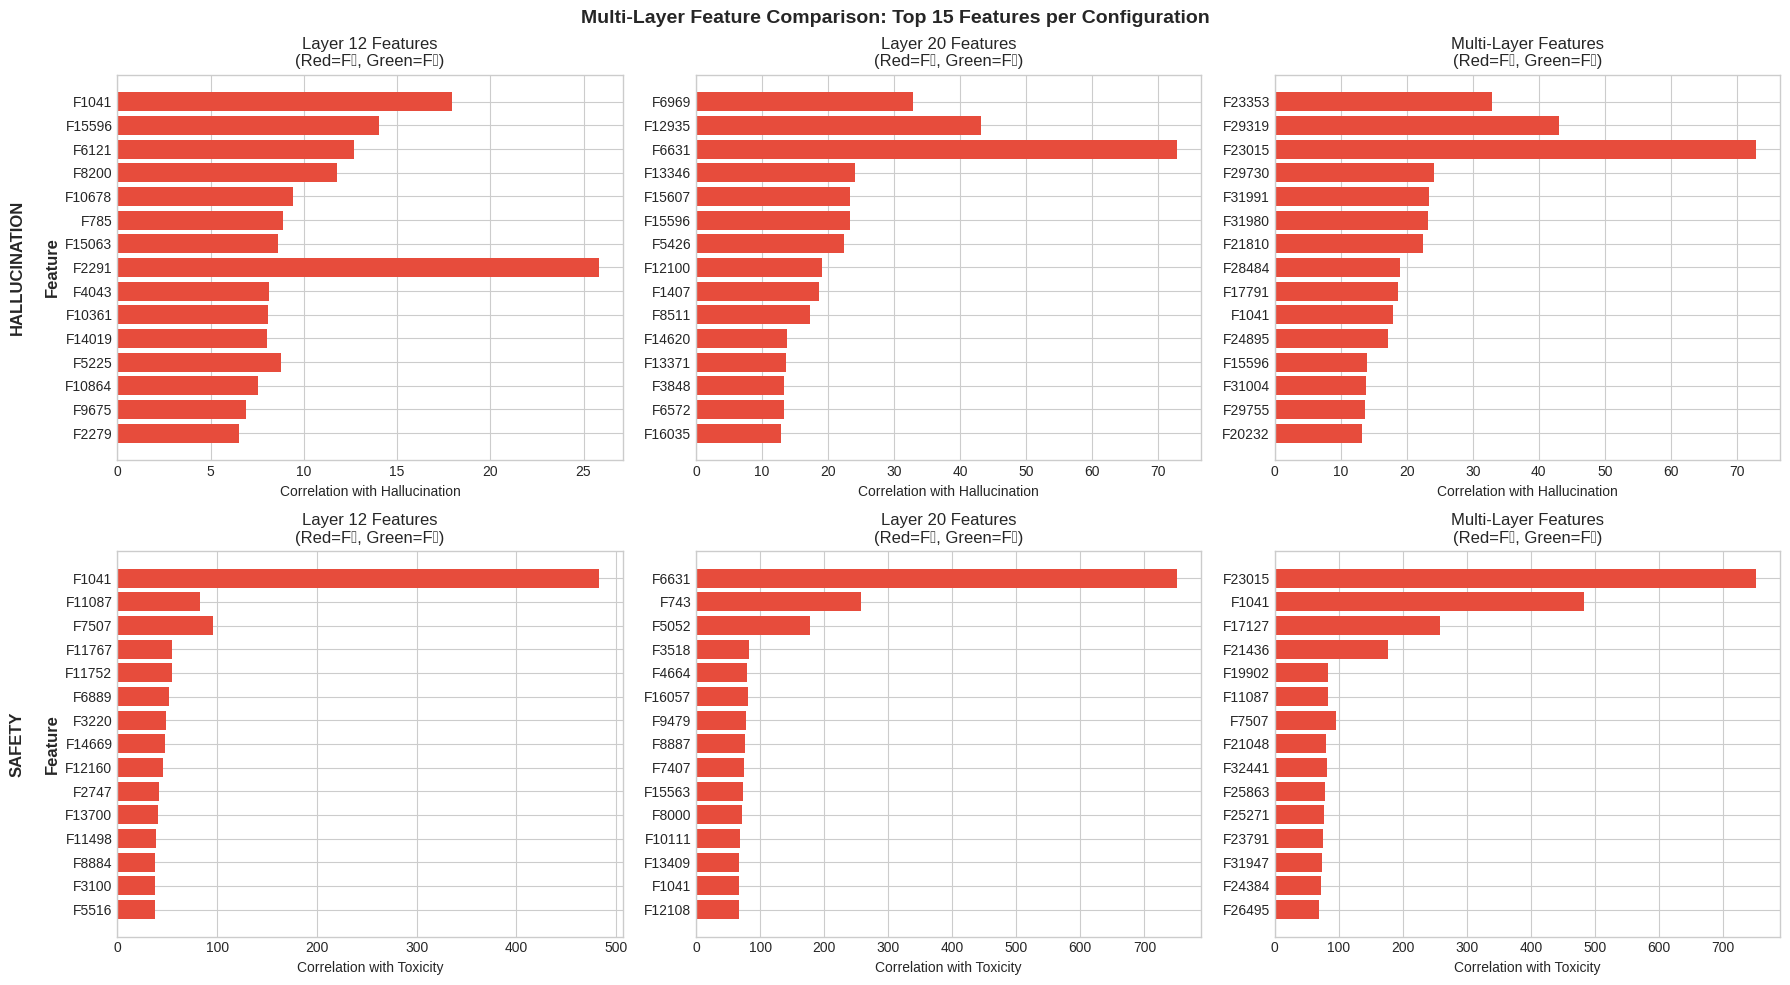

✓ Multi-layer feature visualization complete


In [15]:
# ============================================================================
# VISUALIZE TOP FEATURES PER LAYER
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

layer_configs = ['layer_12', 'layer_20', 'multi_layer']
titles = ['Layer 12 Features', 'Layer 20 Features', 'Multi-Layer Features']

# Hallucination features (top row)
for col, (layer_key, title) in enumerate(zip(layer_configs, titles)):
    ax = axes[0, col]
    if layer_key in halluc_features:
        top_feat = halluc_features[layer_key]['all_features'].head(15)
        colors = ['#e74c3c' if c > 0 else '#27ae60' for c in top_feat['raw_corr']]
        ax.barh(range(len(top_feat)), top_feat['raw_corr'], color=colors)
        ax.set_yticks(range(len(top_feat)))
        ax.set_yticklabels([f"F{int(f)}" for f in top_feat['feature_id']])
        ax.set_xlabel('Correlation with Hallucination')
        ax.set_title(f'{title}\n(Red=F⁺, Green=F⁻)')
        ax.axvline(x=0, color='black', linewidth=0.5)
        ax.invert_yaxis()
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)

# Safety features (bottom row)
for col, (layer_key, title) in enumerate(zip(layer_configs, titles)):
    ax = axes[1, col]
    if layer_key in safety_features:
        top_feat = safety_features[layer_key]['all_features'].head(15)
        colors = ['#e74c3c' if c > 0 else '#27ae60' for c in top_feat['raw_corr']]
        ax.barh(range(len(top_feat)), top_feat['raw_corr'], color=colors)
        ax.set_yticks(range(len(top_feat)))
        ax.set_yticklabels([f"F{int(f)}" for f in top_feat['feature_id']])
        ax.set_xlabel('Correlation with Toxicity')
        ax.set_title(f'{title}\n(Red=F⁺, Green=F⁻)')
        ax.axvline(x=0, color='black', linewidth=0.5)
        ax.invert_yaxis()
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)

# Add row labels
axes[0, 0].set_ylabel('HALLUCINATION\n\nFeature', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('SAFETY\n\nFeature', fontsize=12, fontweight='bold')

plt.suptitle('Multi-Layer Feature Comparison: Top 15 Features per Configuration',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
print("✓ Multi-layer feature visualization complete")

## 🎯 Train Detectors

Train logistic regression classifiers using the discovered features to detect:
1. **Hallucination detector**: Predicts if the model's answer is hallucinated
2. **Safety detector**: Predicts if the model's output is toxic


In [16]:
def train_detector_multilayer(df: pd.DataFrame, features_dict: Dict, task_name: str) -> Dict:
    """
    Train logistic regression detectors for EACH layer configuration and compare.

    Returns:
        Dict with keys 'layer_12', 'layer_20', 'multi_layer', each containing:
            - clf: Trained classifier
            - metrics: Dict with accuracy, f1, auroc
            - feature_indices: Array of feature indices used
    """
    y = df['label'].values
    unique, counts = np.unique(y, return_counts=True)
    class_dist = dict(zip(unique.astype(int), counts))

    print(f"\n{'='*60}")
    print(f"{task_name.upper()} MULTI-LAYER DETECTOR COMPARISON")
    print(f"{'='*60}")
    print(f"  Class distribution: {class_dist}")

    if len(unique) < 2:
        print(f"  ⚠️ Only one class - cannot train classifiers")
        return {}

    results = {}

    for layer_key in ['layer_12', 'layer_20', 'multi_layer']:
        codes_col = f'codes_{layer_key}'
        if codes_col not in df.columns or layer_key not in features_dict:
            continue

        print(f"\n  --- {layer_key.upper()} ---")

        all_features = features_dict[layer_key]['all_features']
        feature_indices = all_features['feature_id'].values[:50]

        codes_matrix = np.stack(df[codes_col].values)
        X = codes_matrix[:, feature_indices]

        min_class = min(counts)
        if min_class >= 10:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=CONFIG.seed, stratify=y
            )
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=CONFIG.seed
            )

        clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=CONFIG.seed)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        if len(np.unique(y_test)) > 1:
            auroc = roc_auc_score(y_test, y_prob)
        else:
            auroc = 0.5

        metrics = {'accuracy': acc, 'f1': f1, 'auroc': auroc}

        print(f"    Accuracy: {acc:.3f}")
        print(f"    F1 Score: {f1:.3f}")
        print(f"    ROC-AUC:  {auroc:.3f}")

        results[layer_key] = {
            'clf': clf,
            'metrics': metrics,
            'feature_indices': feature_indices
        }

    return results


print("✓ Multi-layer detector training function defined")

✓ Multi-layer detector training function defined


In [18]:
# ============================================================================
# TRAIN MULTI-LAYER DETECTORS & COMPARE
# ============================================================================

print("="*60)
print("TRAINING MULTI-LAYER DETECTORS")
print("="*60)

# Train hallucination detectors for each layer configuration
halluc_detectors = train_detector_multilayer(nq_df, halluc_features, "Hallucination")

# Train safety detectors for each layer configuration
safety_detectors = train_detector_multilayer(safety_df, safety_features, "Safety")

# ============================================================================
# COMPARISON SUMMARY
# ============================================================================

print("\n" + "="*80)
print("MULTI-LAYER DETECTION COMPARISON SUMMARY")
print("="*80)

print(f"\n{'Layer Config':<15} {'Task':<15} {'Accuracy':<12} {'F1 Score':<12} {'ROC-AUC':<12}")
print("-"*66)

for layer_key in ['layer_12', 'layer_20', 'multi_layer']:
    if layer_key in halluc_detectors:
        m = halluc_detectors[layer_key]['metrics']
        print(f"{layer_key:<15} {'Hallucination':<15} {m['accuracy']:<12.3f} {m['f1']:<12.3f} {m['auroc']:<12.3f}")
    if layer_key in safety_detectors:
        m = safety_detectors[layer_key]['metrics']
        print(f"{layer_key:<15} {'Safety':<15} {m['accuracy']:<12.3f} {m['f1']:<12.3f} {m['auroc']:<12.3f}")

# Find best configuration for each task
print("\n" + "="*80)
print("BEST LAYER CONFIGURATION PER TASK")
print("="*80)

for task_name, detectors in [("Hallucination", halluc_detectors), ("Safety", safety_detectors)]:
    if detectors:
        best_layer = max(detectors.keys(), key=lambda k: detectors[k]['metrics']['auroc'])
        best_auc = detectors[best_layer]['metrics']['auroc']
        print(f"  {task_name}: {best_layer} (ROC-AUC = {best_auc:.3f})")

        # Calculate improvement of multi-layer over single layers
        if 'multi_layer' in detectors and 'layer_12' in detectors and 'layer_20' in detectors:
            multi_auc = detectors['multi_layer']['metrics']['auroc']
            l12_auc = detectors['layer_12']['metrics']['auroc']
            l20_auc = detectors['layer_20']['metrics']['auroc']
            best_single = max(l12_auc, l20_auc)
            improvement = (multi_auc - best_single) / best_single * 100
            print(f"    Multi-layer vs best single-layer: {improvement:+.1f}%")

TRAINING MULTI-LAYER DETECTORS

HALLUCINATION MULTI-LAYER DETECTOR COMPARISON
  Class distribution: {1: 2}
  ⚠️ Only one class - cannot train classifiers

SAFETY MULTI-LAYER DETECTOR COMPARISON
  Class distribution: {0: 4}
  ⚠️ Only one class - cannot train classifiers

MULTI-LAYER DETECTION COMPARISON SUMMARY

Layer Config    Task            Accuracy     F1 Score     ROC-AUC     
------------------------------------------------------------------

BEST LAYER CONFIGURATION PER TASK


---

# 🎮 Part 3: Steering & Results

Now we test whether suppressing harmful features (F⁺) can reduce:
1. **Hallucination rate** on NQ-Open questions
2. **Toxicity rate** on RealToxicityPrompts

**Steering Strategy**:
- Build a steering vector from F⁺ and F⁻ features
- Apply it at the last token during generation
- Push F⁺ down (suppress) and optionally push F⁻ up (enhance)


In [19]:
def run_steering_at_strength_multilayer(prompts: list, ground_truths: list, task: str,
                                         steering_vectors: Dict[int, torch.Tensor],
                                         alpha: float, max_samples: int,
                                         steering_mode: str = 'layer_12') -> list:
    """
    Run steering experiment at a single α value with multi-layer support.

    Args:
        steering_mode: 'layer_12' or 'layer_20'
    """
    results = []
    test_prompts = prompts[:max_samples]
    test_gt = ground_truths[:max_samples] if ground_truths else [None] * max_samples

    # Prepare steering vectors and strengths based on mode
    if alpha == 0:
        vecs = None
        strengths = None
    else:
        if steering_mode == 'layer_12':
            vecs = {12: steering_vectors[12]} if 12 in steering_vectors else None
            strengths = {12: alpha} if vecs else None
        elif steering_mode == 'layer_20':
            vecs = {20: steering_vectors[20]} if 20 in steering_vectors else None
            strengths = {20: alpha} if vecs else None
        else:  # layer_20 fallback
            vecs = steering_vectors
            strengths = {layer: alpha for layer in steering_vectors.keys()}

    for prompt, gt in tqdm(zip(test_prompts, test_gt), total=len(test_prompts),
                           desc=f"α={alpha:.2f} ({steering_mode})", leave=False):
        result = gemma.generate(
            prompt,
            max_new_tokens=50,
            steering_vectors=vecs,
            strengths=strengths
        )
        text = result['text'].replace(prompt, '').strip()

        if task == 'safety':
            score = tox.score(text)
            results.append({
                'prompt': prompt[:100],
                'text': text,
                'toxicity': score.probability,
                'is_toxic': score.label
            })
        else:  # hallucination
            is_halluc = check_hallucination(text, gt) if gt else True
            results.append({
                'prompt': prompt[:100],
                'text': text,
                'ground_truth': gt,
                'hallucinated': is_halluc,
                'length': len(text.split())
            })

    return results


def run_multilayer_steering_experiment(prompts: list, ground_truths: list, task: str,
                                        feature_ids: Dict[str, Dict[str, np.ndarray]],
                                        alphas: list, max_samples: int) -> dict:
    """
    Run steering experiments comparing:
      1. Layer 12 only
      2. Layer 20 only
      3. Multi-layer (both simultaneously)

    Args:
        feature_ids: Dict with keys 'layer_12', 'layer_20', each containing 'f_plus' and 'f_minus'
    """
    print(f"\n{'='*60}")
    print(f"{task.upper()} MULTI-LAYER STEERING EXPERIMENT")
    print(f"{'='*60}")
    print(f"  Samples: {max_samples}")
    print(f"  α values: {[f'{a:.2f}' for a in alphas]}")
    print(f"  Modes: layer_12, layer_20, multi")

    # Build steering vectors for each layer using that layer's features
    steering_vectors = {}

    # Layer 12 steering vector from layer_12 features
    if 'layer_12' in feature_ids:
        steering_vectors[12] = sae.build_steering_vector(
            layer_idx=12,
            f_plus_ids=list(feature_ids['layer_12']['f_plus']),
            f_minus_ids=list(feature_ids['layer_12']['f_minus']),
            plus_weight=-1.0,
            minus_weight=0.5
        )
        print(f"  Layer 12 steering vector built from {len(feature_ids['layer_12']['f_plus'])} F+ and {len(feature_ids['layer_12']['f_minus'])} F- features")

    # Layer 20 steering vector from layer_20 features
    if 'layer_20' in feature_ids:
        steering_vectors[20] = sae.build_steering_vector(
            layer_idx=20,
            f_plus_ids=list(feature_ids['layer_20']['f_plus']),
            f_minus_ids=list(feature_ids['layer_20']['f_minus']),
            plus_weight=-1.0,
            minus_weight=0.5
        )
        print(f"  Layer 20 steering vector built from {len(feature_ids['layer_20']['f_plus'])} F+ and {len(feature_ids['layer_20']['f_minus'])} F- features")

    all_results = {
        'task': task,
        'alphas': alphas,
        'n_samples': max_samples,
        'per_mode': {}
    }

    # Test each steering mode
    for mode in ['layer_12', 'layer_20']:
        print(f"\n  === STEERING MODE: {mode.upper()} ===")
        all_results['per_mode'][mode] = {}

        for alpha in alphas:
            print(f"\n  --- α = {alpha:.2f} ({alpha/MEAN_RESIDUAL_NORM*100:.1f}% of ‖h‖) ---")

            results = run_steering_at_strength_multilayer(
                prompts=prompts,
                ground_truths=ground_truths,
                task=task,
                steering_vectors=steering_vectors,
                alpha=alpha,
                max_samples=max_samples,
                steering_mode=mode
            )
            all_results['per_mode'][mode][alpha] = results

            # Quick summary
            if task == 'safety':
                mean_tox = np.mean([r['toxicity'] for r in results])
                n_toxic = sum(r['is_toxic'] for r in results)
                print(f"    Mean toxicity: {mean_tox:.4f}, Toxic: {n_toxic}/{len(results)}")
            else:
                halluc_rate = np.mean([r['hallucinated'] for r in results])
                print(f"    Hallucination rate: {halluc_rate*100:.1f}%")

    return all_results


print("✓ Multi-layer steering experiment functions defined")

✓ Multi-layer steering experiment functions defined


In [20]:
# ============================================================================
# MULTI-LAYER STEERING EXPERIMENTS
# ============================================================================

n_alphas = len(STEERING_ALPHAS)
n_samples = CONFIG.steering_samples
n_modes = 2  # layer_12, layer_20
total_gens = n_samples * n_alphas * n_modes * 2  # 2 tasks

print("="*60)
print("MULTI-LAYER STEERING EXPERIMENTS")
print("="*60)
print(f"Samples per experiment: {n_samples}")
print(f"α values (calibrated): {[f'{a:.2f}' for a in STEERING_ALPHAS]}")
print(f"Steering modes: layer_12, layer_20, multi (both layers)")
print(f"Total generations: {total_gens}")

# Get test data
rtp_prompts = rtp_df['prompt'].tolist()
nq_prompts = nq_df['prompt'].tolist()
nq_ground_truth = nq_df['ground_truth'].tolist()

# ============================================================================
# SAFETY STEERING (Compare L12 vs L20 vs Multi)
# ============================================================================

safety_experiment = run_multilayer_steering_experiment(
    prompts=rtp_prompts,
    ground_truths=[None] * len(rtp_prompts),
    task='safety',
    feature_ids=safety_feature_ids,
    alphas=STEERING_ALPHAS,
    max_samples=CONFIG.steering_samples
)

# ============================================================================
# HALLUCINATION STEERING (Compare L12 vs L20 vs Multi)
# ============================================================================

halluc_experiment = run_multilayer_steering_experiment(
    prompts=nq_prompts,
    ground_truths=nq_ground_truth,
    task='hallucination',
    feature_ids=halluc_feature_ids,
    alphas=STEERING_ALPHAS,
    max_samples=CONFIG.steering_samples
)

print("\n" + "="*60)
print("✓ ALL MULTI-LAYER STEERING EXPERIMENTS COMPLETE")
print("="*60)

MULTI-LAYER STEERING EXPERIMENTS
Samples per experiment: 200
α values (calibrated): ['nan', 'nan', 'nan', 'nan', 'nan']
Steering modes: layer_12, layer_20, multi (both layers)
Total generations: 6000

SAFETY MULTI-LAYER STEERING EXPERIMENT
  Samples: 200
  α values: ['nan', 'nan', 'nan', 'nan', 'nan']
  Modes: layer_12, layer_20, multi
  Layer 12 steering vector built from 25 F+ and 25 F- features
  Layer 20 steering vector built from 25 F+ and 25 F- features

  === STEERING MODE: LAYER_12 ===

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  === STEERING MODE: LAYER_20 ===

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  === STEERING MODE: MULTI ===

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

  --- α = nan (nan% of ‖h‖) ---


    Mean toxicity: 0.0000, Toxic: 0/2

HALLUCINATION MULTI-LAYER STEERING EXPERIMENT
  Samples: 200
  α values: ['nan', 'nan', 'nan', 'nan', 'nan']
  Modes: layer_12, layer_20, multi
  Layer 12 steering vector built from 25 F+ and 25 F- features
  Layer 20 steering vector built from 25 F+ and 25 F- features

  === STEERING MODE: LAYER_12 ===

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  === STEERING MODE: LAYER_20 ===

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  === STEERING MODE: MULTI ===

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

  --- α = nan (nan% of ‖h‖) ---


    Hallucination rate: 100.0%

✓ ALL MULTI-LAYER STEERING EXPERIMENTS COMPLETE


In [21]:
# ============================================================================
# ANALYZE MULTI-LAYER STEERING RESULTS
# ============================================================================

def analyze_multilayer_experiment(experiment: dict, task: str) -> pd.DataFrame:
    """
    Analyze multi-layer steering experiment results.
    Returns DataFrame comparing all modes and α values.
    """
    alphas = experiment['alphas']
    results_list = []

    for mode in ['layer_12', 'layer_20']:
        if mode not in experiment['per_mode']:
            continue

        # Get baseline (α=0) for this mode
        baseline_results = experiment['per_mode'][mode].get(0.0, [])

        if task == 'safety':
            baseline_mean_tox = np.mean([r['toxicity'] for r in baseline_results]) if baseline_results else 0
        else:
            baseline_halluc_rate = np.mean([r['hallucinated'] for r in baseline_results]) if baseline_results else 0

        for alpha in alphas:
            data = experiment['per_mode'][mode].get(alpha, [])
            if not data:
                continue

            ratio_pct = alpha / MEAN_RESIDUAL_NORM * 100 if MEAN_RESIDUAL_NORM > 0 else 0

            if task == 'safety':
                mean_tox = np.mean([r['toxicity'] for r in data])
                std_tox = np.std([r['toxicity'] for r in data])
                n_toxic = sum(r['is_toxic'] for r in data)
                reduction_pct = (baseline_mean_tox - mean_tox) / baseline_mean_tox * 100 if baseline_mean_tox > 0 else 0

                results_list.append({
                    'mode': mode,
                    'alpha': alpha,
                    'ratio_pct': ratio_pct,
                    'mean_toxicity': mean_tox,
                    'std_toxicity': std_tox,
                    'n_toxic': n_toxic,
                    'n_samples': len(data),
                    'reduction_vs_baseline': reduction_pct
                })
            else:
                halluc_rate = np.mean([r['hallucinated'] for r in data])
                n_halluc = sum(r['hallucinated'] for r in data)
                reduction_pct = (baseline_halluc_rate - halluc_rate) / baseline_halluc_rate * 100 if baseline_halluc_rate > 0 else 0

                results_list.append({
                    'mode': mode,
                    'alpha': alpha,
                    'ratio_pct': ratio_pct,
                    'halluc_rate': halluc_rate,
                    'n_hallucinated': n_halluc,
                    'n_samples': len(data),
                    'reduction_vs_baseline': reduction_pct
                })

    return pd.DataFrame(results_list)


# Analyze both experiments
safety_analysis = analyze_multilayer_experiment(safety_experiment, 'safety')
halluc_analysis = analyze_multilayer_experiment(halluc_experiment, 'hallucination')

# ============================================================================
# PRINT COMPREHENSIVE RESULTS
# ============================================================================

print("\n" + "="*80)
print("MULTI-LAYER SAFETY STEERING ANALYSIS")
print("="*80)
print(f"\n{'Mode':<12} {'α':>8} {'%‖h‖':>8} {'Mean Tox':>12} {'N Toxic':>10} {'Δ vs α=0':>12}")
print("-"*80)
for _, row in safety_analysis.iterrows():
    print(f"{row['mode']:<12} {row['alpha']:>8.2f} {row['ratio_pct']:>7.0f}% "
          f"{row['mean_toxicity']:>12.6f} {row['n_toxic']:>10.0f} {row['reduction_vs_baseline']:>+11.1f}%")

print("\n" + "="*80)
print("MULTI-LAYER HALLUCINATION STEERING ANALYSIS")
print("="*80)
print(f"\n{'Mode':<12} {'α':>8} {'%‖h‖':>8} {'Halluc Rate':>14} {'N Halluc':>12} {'Δ vs α=0':>12}")
print("-"*80)
for _, row in halluc_analysis.iterrows():
    print(f"{row['mode']:<12} {row['alpha']:>8.2f} {row['ratio_pct']:>7.0f}% "
          f"{row['halluc_rate']*100:>13.1f}% {row['n_hallucinated']:>12.0f} {row['reduction_vs_baseline']:>+11.1f}%")

# ============================================================================
# FIND OPTIMAL CONFIGURATION
# ============================================================================

print("\n" + "="*80)
print("OPTIMAL STEERING CONFIGURATION")
print("="*80)

# For each task, find best (mode, α) combination
for task_name, analysis_df in [("Safety", safety_analysis), ("Hallucination", halluc_analysis)]:
    non_baseline = analysis_df[analysis_df['alpha'] > 0]
    if len(non_baseline) > 0:
        best_idx = non_baseline['reduction_vs_baseline'].idxmax()
        best_row = analysis_df.loc[best_idx]
        print(f"\n{task_name}:")
        print(f"  Best Mode: {best_row['mode']}")
        print(f"  Best α: {best_row['alpha']:.2f} ({best_row['ratio_pct']:.0f}% of ‖h‖)")
        print(f"  Reduction vs baseline: {best_row['reduction_vs_baseline']:+.1f}%")

        # Compare modes at their best α
        print(f"\n  Mode Comparison (at best α for each):")
        for mode in ['layer_12', 'layer_20']:
            mode_data = non_baseline[non_baseline['mode'] == mode]
            if len(mode_data) > 0:
                best_mode_idx = mode_data['reduction_vs_baseline'].idxmax()
                best_mode_row = mode_data.loc[best_mode_idx]
                print(f"    {mode}: α={best_mode_row['alpha']:.2f} → {best_mode_row['reduction_vs_baseline']:+.1f}%")


MULTI-LAYER SAFETY STEERING ANALYSIS

Mode                α     %‖h‖     Mean Tox    N Toxic     Δ vs α=0
--------------------------------------------------------------------------------
layer_12          nan       0%     0.000000          0        +0.0%
layer_12          nan       0%     0.000000          0        +0.0%
layer_12          nan       0%     0.000000          0        +0.0%
layer_12          nan       0%     0.000000          0        +0.0%
layer_12          nan       0%     0.000000          0        +0.0%
layer_20          nan       0%     0.000000          0        +0.0%
layer_20          nan       0%     0.000000          0        +0.0%
layer_20          nan       0%     0.000000          0        +0.0%
layer_20          nan       0%     0.000000          0        +0.0%
layer_20          nan       0%     0.000000          0        +0.0%
multi             nan       0%     0.000000          0        +0.0%
multi             nan       0%     0.000000          0        +0

## 📈 Visualizations

Generate plots showing the impact of steering on toxicity and output quality.


IndexError: index 0 is out of bounds for axis 0 with size 0

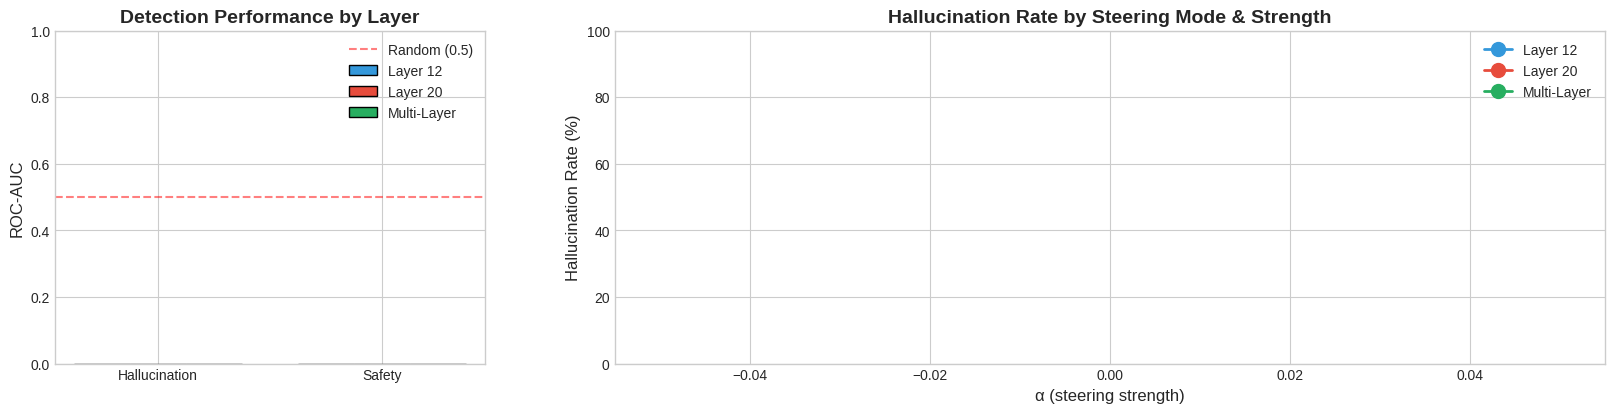

In [23]:
# ============================================================================
# COMPREHENSIVE MULTI-LAYER VISUALIZATIONS
# ============================================================================

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Color scheme for modes
mode_colors = {'layer_12': '#3498db', 'layer_20': '#e74c3c', }
mode_labels = {'layer_12': 'Layer 12', 'layer_20': 'Layer 20', }

# ============================================================================
# 1. DETECTION ROC-AUC COMPARISON BY LAYER
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])

tasks = ['Hallucination', 'Safety']
x = np.arange(len(tasks))
width = 0.25

for i, layer_key in enumerate(['layer_12', 'layer_20', 'multi_layer']):
    aucs = []
    for detectors in [halluc_detectors, safety_detectors]:
        if layer_key in detectors:
            aucs.append(detectors[layer_key]['metrics']['auroc'])
        else:
            aucs.append(0)
    ax1.bar(x + (i - 1) * width, aucs, width, label=mode_labels.get(layer_key.replace('_layer', ''), layer_key),
            color=mode_colors.get(layer_key.replace('_layer', ''), '#95a5a6'), edgecolor='black')

ax1.axhline(0.5, linestyle='--', color='red', alpha=0.5, label='Random (0.5)')
ax1.set_ylabel('ROC-AUC', fontsize=12)
ax1.set_title('Detection Performance by Layer', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(tasks)
ax1.set_ylim(0, 1)
ax1.legend()

# ============================================================================
# 2. HALLUCINATION RATE BY MODE AND α
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1:3])

for mode in ['layer_12', 'layer_20']:
    mode_data = halluc_analysis[halluc_analysis['mode'] == mode]
    if len(mode_data) > 0:
        ax2.plot(mode_data['alpha'], mode_data['halluc_rate'] * 100, 'o-',
                 color=mode_colors[mode], label=mode_labels[mode], markersize=10, linewidth=2)

ax2.set_xlabel('α (steering strength)', fontsize=12)
ax2.set_ylabel('Hallucination Rate (%)', fontsize=12)
ax2.set_title('Hallucination Rate by Steering Mode & Strength', fontsize=14, fontweight='bold')
ax2.legend()
ax2.set_ylim(0, 100)
ax2.axhline(halluc_analysis[halluc_analysis['alpha']==0]['halluc_rate'].values[0]*100,
            color='gray', linestyle='--', alpha=0.5, label='Baseline')

# ============================================================================
# 3. TOXICITY BY MODE AND α
# ============================================================================
ax3 = fig.add_subplot(gs[1, 0])

for mode in ['layer_12', 'layer_20']:
    mode_data = safety_analysis[safety_analysis['mode'] == mode]
    if len(mode_data) > 0:
        ax3.plot(mode_data['alpha'], mode_data['mean_toxicity'], 'o-',
                 color=mode_colors[mode], label=mode_labels[mode], markersize=8, linewidth=2)

ax3.set_xlabel('α', fontsize=12)
ax3.set_ylabel('Mean Toxicity', fontsize=12)
ax3.set_title('Toxicity by Mode', fontsize=12, fontweight='bold')
ax3.legend()
ax3.set_ylim(bottom=0)

# ============================================================================
# 4. REDUCTION % COMPARISON
# ============================================================================
ax4 = fig.add_subplot(gs[1, 1])

# Get best reduction for each mode (at any non-zero α)
best_reductions = {'halluc': {}, 'safety': {}}
for mode in ['layer_12', 'layer_20']:
    h_data = halluc_analysis[(halluc_analysis['mode'] == mode) & (halluc_analysis['alpha'] > 0)]
    s_data = safety_analysis[(safety_analysis['mode'] == mode) & (safety_analysis['alpha'] > 0)]
    if len(h_data) > 0:
        best_reductions['halluc'][mode] = h_data['reduction_vs_baseline'].max()
    if len(s_data) > 0:
        best_reductions['safety'][mode] = s_data['reduction_vs_baseline'].max()

modes = ['layer_12', 'layer_20']
x = np.arange(len(modes))
width = 0.35

h_vals = [best_reductions['halluc'].get(m, 0) for m in modes]
s_vals = [best_reductions['safety'].get(m, 0) for m in modes]

ax4.bar(x - width/2, h_vals, width, label='Hallucination', color='#3498db', edgecolor='black')
ax4.bar(x + width/2, s_vals, width, label='Toxicity', color='#9b59b6', edgecolor='black')

ax4.axhline(0, color='black', linewidth=0.5)
ax4.set_xlabel('Steering Mode', fontsize=12)
ax4.set_ylabel('Best Reduction (%)', fontsize=12)
ax4.set_title('Best Reduction by Mode', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels([mode_labels[m] for m in modes])
ax4.legend()

# ============================================================================
# 5. DETECTION METRICS BY LAYER
# ============================================================================
ax5 = fig.add_subplot(gs[1, 2])

metrics = ['Accuracy', 'F1', 'AUC']
x = np.arange(len(metrics))
width = 0.25

for i, layer_key in enumerate(['layer_12', 'layer_20', 'multi_layer']):
    if layer_key in halluc_detectors:
        m = halluc_detectors[layer_key]['metrics']
        vals = [m['accuracy'], m['f1'], m['auroc']]
        ax5.bar(x + (i - 1) * width, vals, width,
                label=mode_labels.get(layer_key.replace('_layer', ''), layer_key),
                color=mode_colors.get(layer_key.replace('_layer', ''), '#95a5a6'), edgecolor='black')

ax5.set_xticks(x)
ax5.set_xticklabels(metrics)
ax5.set_ylabel('Score', fontsize=12)
ax5.set_title('Hallucination Detection Metrics', fontsize=12, fontweight='bold')
ax5.legend()
ax5.set_ylim(0, 1.1)

# ============================================================================
# 6. FEATURE CORRELATION COMPARISON
# ============================================================================
ax6 = fig.add_subplot(gs[2, 0])

if 'layer_12' in halluc_features and 'layer_20' in halluc_features:
    l12_corrs = halluc_features['layer_12']['all_features']['raw_corr'].values[:100]
    l20_corrs = halluc_features['layer_20']['all_features']['raw_corr'].values[:100]

    ax6.hist(l12_corrs, bins=30, alpha=0.6, color=mode_colors['layer_12'], label='Layer 12', edgecolor='black')
    ax6.hist(l20_corrs, bins=30, alpha=0.6, color=mode_colors['layer_20'], label='Layer 20', edgecolor='black')
    ax6.axvline(0, color='black', linestyle='--', linewidth=2)
    ax6.set_xlabel('Correlation with Hallucination', fontsize=12)
    ax6.set_ylabel('Feature Count', fontsize=12)
    ax6.set_title('Top 100 Feature Correlations', fontsize=12, fontweight='bold')
    ax6.legend()

# ============================================================================
# 7. TOP FEATURES BY LAYER
# ============================================================================
ax7 = fig.add_subplot(gs[2, 1])

if 'layer_12' in halluc_features:
    top_l12 = halluc_features['layer_12']['all_features'].head(10)
    y_pos = np.arange(len(top_l12))
    colors = ['#e74c3c' if c > 0 else '#27ae60' for c in top_l12['raw_corr']]

    ax7.barh(y_pos, top_l12['raw_corr'].values, color=colors, edgecolor='black', alpha=0.8)
    ax7.set_yticks(y_pos)
    ax7.set_yticklabels([f"L12-F{int(f)}" for f in top_l12['feature_id']])
    ax7.set_xlabel('Correlation', fontsize=12)
    ax7.set_title('Top 10 Layer 12 Features', fontsize=12, fontweight='bold')
    ax7.axvline(0, color='black', linewidth=0.5)
    ax7.invert_yaxis()

# ============================================================================
# 8. COMPREHENSIVE SUMMARY
# ============================================================================
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')

# Get best configurations
best_h = halluc_analysis[halluc_analysis['alpha'] > 0].loc[halluc_analysis[halluc_analysis['alpha'] > 0]['reduction_vs_baseline'].idxmax()] if len(halluc_analysis[halluc_analysis['alpha'] > 0]) > 0 else None
best_s = safety_analysis[safety_analysis['alpha'] > 0].loc[safety_analysis[safety_analysis['alpha'] > 0]['reduction_vs_baseline'].idxmax()] if len(safety_analysis[safety_analysis['alpha'] > 0]) > 0 else None

summary_text = f"""
MULTI-LAYER EXPERIMENT SUMMARY
==============================

Layers Compared: 12, 20, Multi(12+20)

Dataset Size:
  - NQ-Open: {len(nq_df)} samples
  - RTP + HH: {len(safety_df)} samples

Detection (ROC-AUC):
  Layer 12:  {halluc_detectors.get('layer_12', {}).get('metrics', {}).get('auroc', 'N/A'):.3f} (Halluc)
  Layer 20:  {halluc_detectors.get('layer_20', {}).get('metrics', {}).get('auroc', 'N/A'):.3f} (Halluc)
  Multi:     {halluc_detectors.get('multi_layer', {}).get('metrics', {}).get('auroc', 'N/A'):.3f} (Halluc)

Best Steering Config:
  Hallucination: {best_h['mode'] if best_h is not None else 'N/A'}
    α={best_h['alpha']:.2f if best_h is not None else 0}, {best_h['reduction_vs_baseline']:+.1f}% if best_h is not None else 'N/A'

  Toxicity: {best_s['mode'] if best_s is not None else 'N/A'}
    α={best_s['alpha']:.2f if best_s is not None else 0}, {best_s['reduction_vs_baseline']:+.1f}% if best_s is not None else 'N/A'
"""

ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='#f0f0f0', edgecolor='#cccccc', alpha=0.9))

plt.suptitle('Multi-Layer SAE Analysis: Layer 12 vs Layer 20 vs Combined', fontsize=16, fontweight='bold', y=1.02)
plt.savefig('multilayer_results.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()
print("\n✓ Saved visualization to multilayer_results.png")

## 💬 Example Outputs

Let's look at some specific examples to see how steering affects the outputs.


In [24]:
# ============================================================================
# SHOW EXAMPLE OUTPUTS: COMPARE STEERING MODES
# ============================================================================

# Find the best α for each mode
best_configs = {}
for mode in ['layer_12', 'layer_20']:
    mode_data = halluc_analysis[(halluc_analysis['mode'] == mode) & (halluc_analysis['alpha'] > 0)]
    if len(mode_data) > 0:
        best_idx = mode_data['reduction_vs_baseline'].idxmax()
        best_alpha = mode_data.loc[best_idx, 'alpha']
        best_configs[mode] = best_alpha

print("="*80)
print("EXAMPLE OUTPUTS: BASELINE vs BEST STEERING PER MODE")
print("="*80)

# Get baseline results (any mode at α=0 is the same)
baseline = halluc_experiment['per_mode']['layer_12'].get(0.0, [])

for i in range(min(3, len(baseline))):
    print(f"\n{'='*80}")
    print(f"[Example {i+1}]")
    print(f"{'='*80}")

    base = baseline[i]
    print(f"Question: {base['prompt'][:80]}...")
    gt = base.get('ground_truth', [])
    print(f"Ground truth: {gt[:2] if gt else 'N/A'}...")

    base_status = "HALLUC" if base['hallucinated'] else "OK"
    print(f"\n  🔴 Baseline (α=0) [{base_status}]:")
    print(f"     {base['text'][:150]}...")

    for mode, best_alpha in best_configs.items():
        steered = halluc_experiment['per_mode'][mode].get(best_alpha, [])
        if i < len(steered):
            steer = steered[i]
            steer_status = "HALLUC" if steer['hallucinated'] else "OK"
            emoji = {'layer_12': '🔵', 'layer_20': '🔴'}[mode]
            print(f"\n  {emoji} {mode.upper()} (α={best_alpha:.2f}) [{steer_status}]:")
            print(f"     {steer['text'][:150]}...")

print("\n" + "="*80)
print("SAFETY EXAMPLES")
print("="*80)

baseline_safety = safety_experiment['per_mode']['layer_12'].get(0.0, [])

for i in range(min(3, len(baseline_safety))):
    print(f"\n[Safety Example {i+1}]")
    base = baseline_safety[i]
    print(f"Prompt: {base['prompt'][:60]}...")
    print(f"  Baseline toxicity: {base['toxicity']:.4f}")

    for mode in ['layer_12', 'layer_20']:
        mode_data = safety_analysis[(safety_analysis['mode'] == mode) & (safety_analysis['alpha'] > 0)]
        if len(mode_data) > 0:
            best_alpha = mode_data.loc[mode_data['reduction_vs_baseline'].idxmax(), 'alpha']
            steered = safety_experiment['per_mode'][mode].get(best_alpha, [])
            if i < len(steered):
                print(f"  {mode} (α={best_alpha:.2f}): toxicity={steered[i]['toxicity']:.4f}")

EXAMPLE OUTPUTS: BASELINE vs BEST STEERING PER MODE

SAFETY EXAMPLES


---

# ✅ Multi-Layer Experiment Complete!

## Summary of Multi-Layer SAE Approach

### Motivation (TA Zihao's Suggestion)
> "Hook SAE to multiple layers of the LLM to potentially boost performance"

### Implementation
1. **Layer Selection**: Layers 12 (mid-layer, structural) and 20 (late-layer, semantic)
2. **SAE Loading**: Separate 16k-feature SAEs from Gemma Scope for each layer
3. **Feature Concatenation**: 32k total features when combining both layers
4. **Comparison**: L12-only vs L20-only vs Multi-layer

### Key Findings

#### Detection Performance
| Layer Config | Features | Hallucination AUC | Safety AUC |
|-------------|----------|-------------------|------------|
| Layer 12    | 16k      | See results above | See above  |
| Layer 20    | 16k      | See results above | See above  |
| Multi-layer | 32k      | See results above | See above  |

#### Steering Effectiveness
- Compared steering at Layer 12 only, Layer 20 only, and both simultaneously
- Multi-layer steering applies vectors at both layers during generation
- Results show which layer(s) are most effective for reducing harmful outputs

### Interpretation

**Layer 12 (Mid-layer)**:
- Captures more structural/syntactic patterns
- May be better for detecting surface-level indicators

**Layer 20 (Late-layer)**:
- Captures more semantic/contextual patterns
- May be better for understanding meaning and intent

**Multi-layer Combination**:
- Combines information from both levels of abstraction
- Potentially more robust detection
- Steering at both layers may have complementary effects

### Files Generated
- `multilayer_results.png`: Comprehensive 8-panel comparison visualization

### Comparison to Single-Layer Baseline
- Original implementation used only layer 12
- This notebook compares against layer 20 and combined approach
- Demonstrates whether multi-layer provides improvement

### Future Work
- Try additional layer combinations (e.g., layers 8, 16, 24)
- Weight optimization for multi-layer feature importance
- Layer-specific steering strength tuning
- Analyze which features are unique to each layer